In [139]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
from PIL import Image
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout, Input,Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.models import model_from_json

In [115]:
source="D:\\data analytics\\S2\\Ml lab\\dataset\\distracted driver\\train\\"

In [116]:
def getTrainFiles(classIndex):
    trainDir=source+"c"+str(classIndex)
    files=[os.path.join(trainDir, f) for f in os.listdir(trainDir)]
    return files

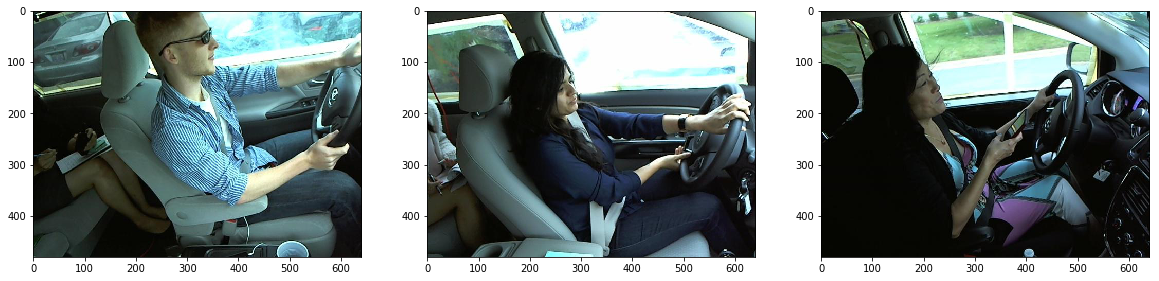

D:\data analytics\S2\Ml lab\dataset\distracted driver\train\c0\img_100026.jpg
D:\data analytics\S2\Ml lab\dataset\distracted driver\train\c0\img_10003.jpg
D:\data analytics\S2\Ml lab\dataset\distracted driver\train\c1\img_100021.jpg


In [117]:
c0Files= getTrainFiles(0)
c1Files=getTrainFiles(1)

# img=mpimg.imread(c0Files[0])
# imgplot = plt.imshow(img)
# img.shape
# plt.show()
c01=mpimg.imread(c0Files[0])
c02=mpimg.imread(c0Files[1])
c11=mpimg.imread(c1Files[0])
fig,axes=plt.subplots(1,3,figsize=(20, 20))
axes[0].imshow(c01)
axes[1].imshow(c02)
axes[2].imshow(c11)
plt.show()
print(c0Files[0])
print(c0Files[1])
print(c1Files[0])

In [128]:
# Create a class to store global variables. Easier for adjustments.
class Configuration:
    def __init__(self):
        self.epochs = 15
        self.batch_size = 50
        self.maxwidth =0
        self.maxheight=0
        self.minwidth = 35000
        self.minheight = 35000
        self.imgcount=0
        self.img_width_adjust = 480
        self.img_height_adjust= 360
        self.data_dir = source
config = Configuration()

In [129]:
#Count the number of files in each subdirectory
def listDirectoryCounts(path):
    d = []
    for subdir, dirs_in_subdir, files in os.walk(path,topdown=False):
        filecount = len(files)
        dirname = subdir
        d.append((dirname,filecount))
    return d 

def SplitCat(df):
    for index, row in df.iterrows():
        directory=row['Category'].split('\\')
        if directory[-1]!='':
            directory=directory[-1]
            df.at[index,'Category']=directory
        else:
            df.drop(index, inplace=True)
    return
#Get image count per category
dirCount=listDirectoryCounts(config.data_dir)
categoryInfo = pd.DataFrame(dirCount, columns=['Category','Count'])
SplitCat(categoryInfo)
categoryInfo=categoryInfo.sort_values(by=['Category'])
print(categoryInfo.to_string(index=False))

Category  Count
     c0   2489
     c1   2267
     c2   2317
     c3   2346
     c4   2326
     c5   2312
     c6   2325
     c7   2002
     c8   1911
     c9   2129


In [130]:
#Find the largest and smallest dimensions of all the pictures
def findPictureDims(path):
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                config.imgcount+=1
                filename = os.path.join(subdir, file)
                image = Image.open(filename)
                width, height = image.size
                if width < config.minwidth:
                    config.minwidth = width
                if height < config.minheight:
                    config.minheight = height
                if width > config.maxwidth:
                    config.maxwidth = width
                if height > config.maxheight:
                    config.maxheight = height
    return
findPictureDims(config.data_dir)
print("Minimum Width:\t",config.minwidth, "\tMinimum Height:",config.minheight)
print("Maximum Width:\t",config.maxwidth, "\tMaximum Height:",config.maxheight, "\tImage Count:\t",config.imgcount)

Minimum Width:	 640 	Minimum Height: 480
Maximum Width:	 640 	Maximum Height: 480 	Image Count:	 22424


In [131]:
#Alexnet Model Definition
def build_model():
   
    #Instantiate an empty model
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(filters=96, input_shape=(224,224,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'))
    model.add(Activation('relu'))
    # Max Pooling
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

    # Passing it to a Fully Connected layer
    model.add(Flatten())
    # 1st Fully Connected Layer
    model.add(Dense(4096, input_shape=(224*224*3,)))
    model.add(Activation('relu'))
    # Add Dropout to prevent overfitting
    model.add(Dropout(0.4))

    # 2nd Fully Connected Layer
    model.add(Dense(4096))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))

    # 3rd Fully Connected Layer
    model.add(Dense(1000))
    model.add(Activation('relu'))
    # Add Dropout
    model.add(Dropout(0.4))

    # Output Layer
    model.add(Dense(10))
    model.add(Activation('softmax'))

    # Compile the model
    sgd = SGD(lr=0.0009, decay=0.00001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=["accuracy"])
    return model

In [132]:
#Setup data, and create split for training, testing 80/20
def setup_data(train_data_dir, val_data_dir, img_width=config.img_width_adjust, img_height=config.img_height_adjust, batch_size=config.batch_size):
    
    train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')
    
    validation_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')
        #Note uses training dataflow generator
    return train_generator, validation_generator

In [133]:
def fit_model(model, train_generator, val_generator, batch_size, epochs):
    model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=val_generator.samples // batch_size,
        verbose=1)
    return model



In [134]:
def eval_model(model, val_generator, batch_size):
    scores = model.evaluate_generator(val_generator, steps=val_generator.samples // batch_size)
    print("Loss: " + str(scores[0]) + " Accuracy: " + str(scores[1]))


In [135]:
# Create Data 80/20
train_generator, val_generator = setup_data(config.data_dir, config.data_dir, batch_size=config.batch_size,img_width=224, img_height=224)


Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [136]:
# Build the model and show the summary data (note trainable parameters)
model = build_model()
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
activation_46 (Activation)   (None, 54, 54, 96)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 17, 17, 256)       2973952   
_________________________________________________________________
activation_47 (Activation)   (None, 17, 17, 256)       0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 6, 6, 384)         885120    
__________

In [137]:
# Fit the model, note this takes about 1 hr 40 mins with GPU
model = fit_model(model, train_generator, val_generator,
                  batch_size=config.batch_size,
                  epochs=config.epochs)

Epoch 1/15
358/358 [==============================] - 458s 1s/step - loss: 2.3013 - acc: 0.1084 - val_loss: 2.3001 - val_acc: 0.1106
Epoch 2/15
358/358 [==============================] - 367s 1s/step - loss: 2.3000 - acc: 0.1111 - val_loss: 2.2991 - val_acc: 0.1110
Epoch 3/15
358/358 [==============================] - 361s 1s/step - loss: 2.2993 - acc: 0.1115 - val_loss: 2.2984 - val_acc: 0.1106
Epoch 4/15
358/358 [==============================] - 362s 1s/step - loss: 2.2989 - acc: 0.1130 - val_loss: 2.2978 - val_acc: 0.1119
Epoch 5/15
358/358 [==============================] - 372s 1s/step - loss: 2.2976 - acc: 0.1165 - val_loss: 2.2955 - val_acc: 0.1108
Epoch 6/15
358/358 [==============================] - 391s 1s/step - loss: 2.2957 - acc: 0.1212 - val_loss: 2.2905 - val_acc: 0.1275
Epoch 7/15
358/358 [==============================] - 399s 1s/step - loss: 2.2881 - acc: 0.1429 - val_loss: 2.2732 - val_acc: 0.1426
Epoch 8/15
358/358 [==============================] - 387s 1s/step - 

In [138]:
# Evaluate your model.
eval_model(model, val_generator, batch_size=config.batch_size)

Loss: 0.3895024124056242 Accuracy: 0.866621525084238


In [140]:
# serialize model to JSON
model_json = model.to_json()
with open("dd_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("dd_model.h5")
print("Saved model to disk")

Saved model to disk


In [57]:
#view results on test set
sample_data_dir="D:\\data analytics\\S2\\Ml lab\\dataset\\distracted driver\\train\\"
viewmodel_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split
    

    train_generator = viewmodel_datagen.flow_from_directory(
        sample_data_dir,
        target_size=(224, 224),
        batch_size=config.batch_size,
        class_mode='categorical')

['/device:GPU:0']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9945497038680576423
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3206820659
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7268114087206007877
physical_device_desc: "device: 0, name: GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]
